In [1]:
import os

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from network import Generator, MultiscaleDiscriminator
from loss import GANLoss, VGGLoss, FMLoss
from dataloader import ImageData

# Data

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
G = Generator(6, 3).to(device)

In [8]:
D = MultiscaleDiscriminator(12, getIntermFeat=True).to(device)

# Loss

In [9]:
gan_loss = GANLoss('lsgan', device)
vgg_loss = VGGLoss(device)
fm_loss = FMLoss(device)

In [10]:
# optimizaer
optim_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# DataSet

In [11]:
import torch.utils.data as data

In [12]:
import os

In [13]:
from PIL import Image

In [14]:
# data는 4개가 나오도록 설정 (실제 (x-1, x), pose (x-1, x))
# generator는 실제(x-1)와 pose(x)을 입력
# discrimiator는 (실제 (x-1, x) pose (x-1, x))이 되도록, (generative(x-1, x) pose(x-1, x))이 되도록 학습
# (실제 (x-1, x) pose (x-1, x))을 학습, 그 후, 

In [15]:
imageData = ImageData('data/image/origin', 'data/image/pose', transform=transform)

In [16]:
DataLoader = data.DataLoader(imageData, batch_size=1)

In [17]:
num_epoch = 10

In [18]:
def imshow(img, title, size=(5, 5)):
    npimg = img.numpy()
    fig = plt.figure(figsize=size)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [19]:
G.load_state_dict(torch.load('models/G_001_18999.pkl'))
D.load_state_dict(torch.load('models/D_001_18999.pkl'))

Epoch [0/10], Iter [1000/19675], D_loss: 0.0010, G_loss: 6.5033


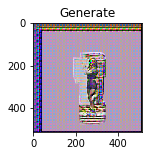

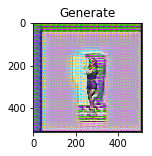

Epoch [0/10], Iter [2000/19675], D_loss: 0.0006, G_loss: 6.5164


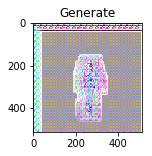

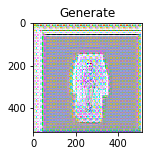

Epoch [0/10], Iter [3000/19675], D_loss: 0.0027, G_loss: 6.6491


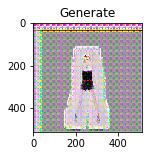

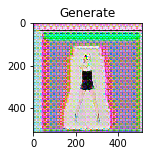

Epoch [0/10], Iter [4000/19675], D_loss: 0.0005, G_loss: 6.4530


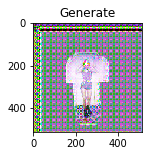

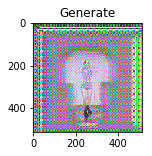

Epoch [0/10], Iter [5000/19675], D_loss: 0.0005, G_loss: 6.5400


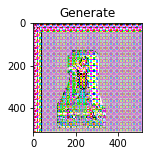

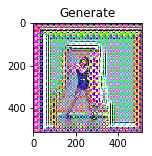

Epoch [0/10], Iter [6000/19675], D_loss: 0.0003, G_loss: 6.5497


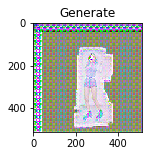

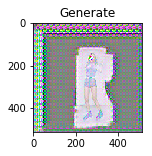

Epoch [0/10], Iter [7000/19675], D_loss: 0.0003, G_loss: 6.3117


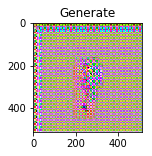

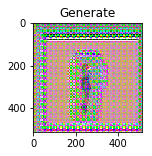

Epoch [0/10], Iter [8000/19675], D_loss: 0.0003, G_loss: 6.1147


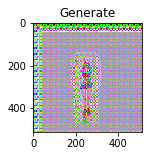

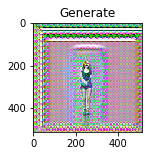

Epoch [0/10], Iter [9000/19675], D_loss: 0.0006, G_loss: 5.9817


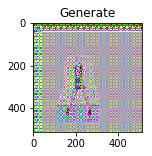

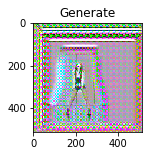

Epoch [0/10], Iter [10000/19675], D_loss: 0.0004, G_loss: 6.0129


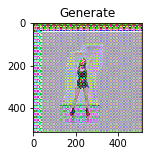

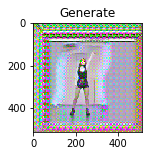

Epoch [0/10], Iter [11000/19675], D_loss: 0.0003, G_loss: 5.8537


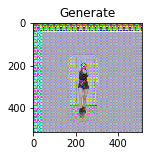

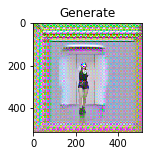

Epoch [0/10], Iter [12000/19675], D_loss: 0.0001, G_loss: 5.8031


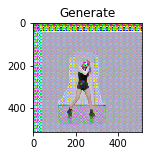

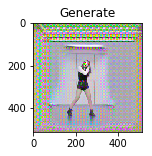

Epoch [0/10], Iter [13000/19675], D_loss: 0.0005, G_loss: 6.3523


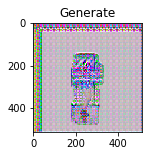

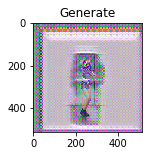

Epoch [0/10], Iter [14000/19675], D_loss: 0.0002, G_loss: 6.2077


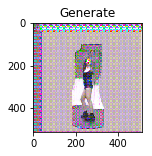

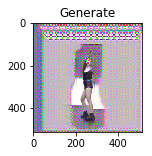

Epoch [0/10], Iter [15000/19675], D_loss: 0.0008, G_loss: 6.0061


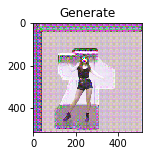

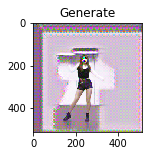

Epoch [0/10], Iter [16000/19675], D_loss: 0.0002, G_loss: 5.8768


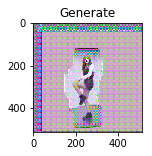

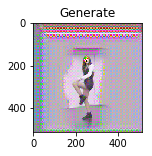

Epoch [0/10], Iter [17000/19675], D_loss: 0.0005, G_loss: 5.7964


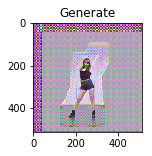

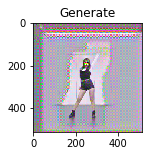

Epoch [0/10], Iter [18000/19675], D_loss: 0.0005, G_loss: 5.7935


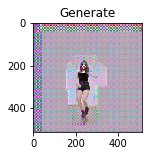

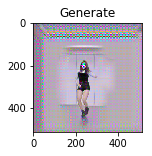

Epoch [0/10], Iter [19000/19675], D_loss: 0.0003, G_loss: 5.8206


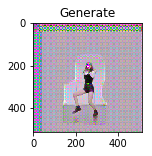

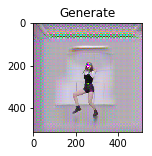

IndexError: list index out of range

In [20]:
# Train
for epoch in range(num_epoch):
    total_batch = len(imageData)

    for idx, (set_pre, set_cur) in enumerate(DataLoader):
        D.train()
        G.train()
        
        set_pre = set_pre.to(device)
        set_cur = set_cur.to(device)
        
        # fake2
        # fake_first 
        img_zero = torch.zeros((set_cur.size(0), 3, set_cur.size(2), set_cur.size(3))).to(device)
        img_fake_pre = G(torch.cat([img_zero, set_pre[:,3:,:,:]], dim=1))
        img_fake_cur = G(torch.cat([img_fake_pre.detach(), set_cur[:,3:,:,:]], dim=1))
        
        
        # Fake Detection and Loss
        output_fake = D(torch.cat([img_fake_pre.detach(), set_pre[:,3:,:,:], img_fake_cur.detach(), set_cur[:,3:,:,:]], dim=1))
        D_loss_fake = gan_loss(output_fake, False)
        
        # Real Detection and Loss
        output_real = D(torch.cat([set_pre, set_cur], dim=1))
        D_loss_real = gan_loss(output_real, True)
        
        # GAN loss 
        output_fake_g = D(torch.cat([img_fake_pre, set_pre[:,3:,:,:], img_fake_cur, set_cur[:,3:,:,:]], dim=1))
        G_loss = gan_loss(output_fake_g, True)
        
        # VGG loss
        VGG_loss_cur = vgg_loss(img_fake_cur, set_cur[:,:3,:,:])
        VGG_loss_pre = vgg_loss(img_fake_pre, set_pre[:,:3,:,:])
        
        # Feature Matching loss
        FM_loss = fm_loss(output_fake_g, output_real)
        
        D_loss_total = (D_loss_fake + D_loss_real) * 0.5
        G_loss_total = G_loss + 1 * (VGG_loss_cur + VGG_loss_pre) + 1 * FM_loss

        optim_G.zero_grad()
        G_loss_total.backward()
        optim_G.step()
        
        optim_D.zero_grad()
        D_loss_total.backward()
        optim_D.step()
        
        if (idx+1) % 1000 == 0:
            print('Epoch [%d/%d], Iter [%d/%d], D_loss: %.4f, G_loss: %.4f'
                 %(epoch, num_epoch, idx+1, total_batch, D_loss_total.item(), G_loss_total.item()))
            
            G.eval()
            D.eval()

            ## check Image
            img =  G(torch.cat([img_zero[:1,:,:,:], set_pre[:1,3:,:,:]], dim=1))
            img2 = G(torch.cat([img, set_cur[:1,3:,:,:]], dim=1))
            imshow(torchvision.utils.make_grid(img.squeeze().data.cpu(), normalize=True), "Generate", size=(2,2))
            imshow(torchvision.utils.make_grid(img2.squeeze().data.cpu(), normalize=True), "Generate", size=(2,2))
            
            ## save
            torch.save(G.state_dict(), 'models/G_{:03d}_{:03d}.pkl'.format(epoch+1, idx))
            torch.save(D.state_dict(), 'models/D_{:03d}_{:03d}.pkl'.format(epoch+1, idx))

# Test

In [23]:
imageData2 = ImageData('data_target/image/origin', 'data_target/image/pose', transform=transform)

In [24]:
DataLoader = data.DataLoader(imageData2, batch_size=1)

In [25]:
G.load_state_dict(torch.load('models/G_001_18999.pkl'))

In [26]:
def imsave(tensor, name, dir_save='result'):
    import os
    
    filename = os.path.join(dir_save, name)
    torchvision.utils.save_image(tensor, normalize=True, filename=filename)

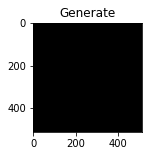

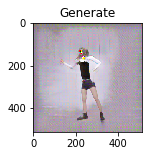

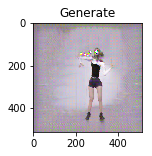

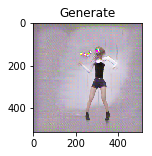

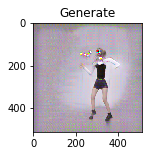

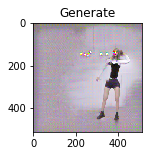

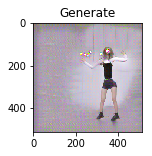

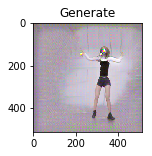

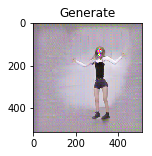

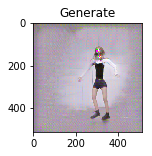

KeyboardInterrupt: 

In [27]:
for idx, (set_pre, set_cur) in enumerate(DataLoader):
    G.eval()
    
    set_pre = set_pre.to(device)
    set_cur = set_cur.to(device)
    
    if idx == 0:
        img_fake_pre = torch.zeros((set_cur.size(0), 3, set_cur.size(2), set_cur.size(3))).to(device)
    
    img_fake = G(torch.cat([img_fake_pre, set_pre[:,3:,:,:]], dim=1))
    #imsave(img_fake.data.cpu(), name=str(idx)+'.png')
    
    if idx % 50 == 0:
        imshow(torchvision.utils.make_grid(img_fake_pre.squeeze().data.cpu(), normalize=True), "Generate", size=(2,2))
    img_fake_pre = img_fake.data